In [2]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [3]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [4]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth']

#### Corpus laden

In [5]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [6]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [7]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [9]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [10]:
sparse_bow[:5]

0
doc_id token_id   
1      4098      1
       20483     3
       21277     1
       9411      1
       8199      1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [11]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [12]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [13]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [14]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [15]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [16]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Find hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [17]:
len(features_to_be_removed)

75

In [18]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [19]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 192053 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [20]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [21]:
len(doc2bow_list)

17

In [22]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 10 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 20x with a convergence threshold of 0.001000
INFO gensim.models.ldamodel: -14.377 per-word bound, 21280.8 perplexity estimate based on a held-out corpus of 17 documents with 192053 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #5 (0.050): 0.003*"resting" + 0.003*"left" + 0.003*"radha" + 0.003*"mortimer" + 0.003*"sifted" + 0.003*"each-end" + 0.003*"revoir" + 0.003*"impetus" + 0.003*"corridors" + 0.003*"broadening"
INFO gensim.models.ldamodel: topic #9 (0.050): 0.003*"sifted" + 0.003*"left" + 0.003*"impetus" + 0.003*"rotati

In [23]:
model.get_document_topics(doc2bow_list[1])

[(0, 0.13167135367236593),
 (1, 0.069001016387639932),
 (4, 0.10473627468687931),
 (5, 0.1004043862901995),
 (6, 0.036912782758787753),
 (8, 0.043331978713068285),
 (9, 0.089898997630630681),
 (12, 0.26446716653188845),
 (15, 0.13535590224794253)]

In [24]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['fierce-eyed',
 'radha',
 'toronto',
 'produce',
 'recklessly',
 'retorts',
 'sifted',
 'sally',
 'disciples',
 'nd']

In [25]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic in topics:
    idx = topic[0]
    temp = topic[1]
    topics_df.loc[idx] = temp
        
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(infamy, 0.00942058548937)","(dodging, 0.00775093867522)","(douche, 0.00500425123477)","(wounded, 0.00440825060926)","(vitals, 0.00421797220584)","(injustice, 0.00386919405145)","(rotation, 0.00383464595995)","(corridors, 0.00369199364721)","(goal, 0.00368854463022)","(sifted, 0.00357396804849)"
1,"(fierce-eyed, 0.00876069669552)","(radha, 0.00582426403017)","(toronto, 0.00412736129402)","(produce, 0.00400646730901)","(recklessly, 0.0039339518436)","(retorts, 0.00333922182936)","(sifted, 0.00327653695383)","(sally, 0.00322464902419)","(disciples, 0.00318923167125)","(nd, 0.00312480525947)"
2,"(cottage, 0.00734787127314)","(bazars, 0.00649651895263)","(scouring, 0.00606024830104)","(evilly, 0.0036004343027)","(entangle, 0.0035229239413)","(legislation, 0.00347131983325)","(mister-kent, 0.00315113626552)","(portraits, 0.00308663284317)","(deserted, 0.00307731269285)","(unique, 0.00304414163096)"
3,"(hocus-pocus, 0.00773331991114)","(involves, 0.0067750014097)","(radha, 0.0046926879271)","(geometrically, 0.00426739539374)","(toronto, 0.00406485594463)","(fairy, 0.00403229918124)","(ringed, 0.00398332121315)","(elevations, 0.00375914556856)","(drum, 0.00328871593551)","(torrents, 0.00324901366541)"
4,"(dodging, 0.00450354254105)","(corridors, 0.0043272535329)","(vitals, 0.00427231332268)","(clotted, 0.0041324743117)","(lattice, 0.00391791469164)","(reeled, 0.00388960424145)","(revoir, 0.00376955632721)","(legiance, 0.00329913310167)","(cotton, 0.00327591918239)","(pole-cat, 0.00309696113169)"
5,"(lomar, 0.00715148300425)","(rome, 0.00495839329889)","(nd, 0.00494942793894)","(left, 0.00458624188979)","(necromancer, 0.00445087104813)","(bursts, 0.00414818932982)","(horn-like, 0.0041130866504)","(malignancy, 0.00402335324306)","(unconcealed, 0.00397404056007)","(broadening, 0.00395707353245)"
6,"(fierce-eyed, 0.0141326532063)","(treasures, 0.00611085342654)","(disciples, 0.00503259359449)","(witchlike, 0.00469775378115)","(surgeon, 0.00449504696252)","(toronto, 0.0043832073492)","(sifted, 0.00417910394832)","(left, 0.00385252557266)","(torrents, 0.00367760620555)","(radha, 0.0034733671404)"
7,"(malignancy, 0.000286583399862)","(vitals, 0.000274208657771)","(impetus, 0.000259835145173)","(radha, 0.000249034090363)","(corridors, 0.000247292919763)","(elevations, 0.00024497815456)","(practicable, 0.000243050744663)","(sifted, 0.000242226752263)","(evilly, 0.000241474634915)","(revoir, 0.000234230968683)"
8,"(exchange, 0.00830182515173)","(evilly, 0.00607413500598)","(mister-kent, 0.00401899325729)","(entangle, 0.00289976186428)","(sally, 0.00281713040554)","(sombre, 0.00261368194486)","(consoled, 0.00260760652127)","(stone-shadowed, 0.00257660589823)","(roerich's, 0.00247144829419)","(lip, 0.00245685613833)"
9,"(prodigiously, 0.0126882279865)","(wouldn't, 0.00907219012115)","(sensitive, 0.00821181664535)","(impenetrability, 0.00727259042424)","(elderly, 0.0068344622938)","(fray, 0.00660868100538)","(pranceful, 0.00636574905297)","(sifted, 0.00625784486794)","(mortimer, 0.00593866528805)","(overlook, 0.00554728750318)"


In [26]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(infamy, 0.00942058548937)","(dodging, 0.00775093867522)","(douche, 0.00500425123477)","(wounded, 0.00440825060926)","(vitals, 0.00421797220584)","(injustice, 0.00386919405145)","(rotation, 0.00383464595995)","(corridors, 0.00369199364721)","(goal, 0.00368854463022)","(sifted, 0.00357396804849)"
1,"(fierce-eyed, 0.00876069669552)","(radha, 0.00582426403017)","(toronto, 0.00412736129402)","(produce, 0.00400646730901)","(recklessly, 0.0039339518436)","(retorts, 0.00333922182936)","(sifted, 0.00327653695383)","(sally, 0.00322464902419)","(disciples, 0.00318923167125)","(nd, 0.00312480525947)"
2,"(cottage, 0.00734787127314)","(bazars, 0.00649651895263)","(scouring, 0.00606024830104)","(evilly, 0.0036004343027)","(entangle, 0.0035229239413)","(legislation, 0.00347131983325)","(mister-kent, 0.00315113626552)","(portraits, 0.00308663284317)","(deserted, 0.00307731269285)","(unique, 0.00304414163096)"
3,"(hocus-pocus, 0.00773331991114)","(involves, 0.0067750014097)","(radha, 0.0046926879271)","(geometrically, 0.00426739539374)","(toronto, 0.00406485594463)","(fairy, 0.00403229918124)","(ringed, 0.00398332121315)","(elevations, 0.00375914556856)","(drum, 0.00328871593551)","(torrents, 0.00324901366541)"
4,"(dodging, 0.00450354254105)","(corridors, 0.0043272535329)","(vitals, 0.00427231332268)","(clotted, 0.0041324743117)","(lattice, 0.00391791469164)","(reeled, 0.00388960424145)","(revoir, 0.00376955632721)","(legiance, 0.00329913310167)","(cotton, 0.00327591918239)","(pole-cat, 0.00309696113169)"
5,"(lomar, 0.00715148300425)","(rome, 0.00495839329889)","(nd, 0.00494942793894)","(left, 0.00458624188979)","(necromancer, 0.00445087104813)","(bursts, 0.00414818932982)","(horn-like, 0.0041130866504)","(malignancy, 0.00402335324306)","(unconcealed, 0.00397404056007)","(broadening, 0.00395707353245)"
6,"(fierce-eyed, 0.0141326532063)","(treasures, 0.00611085342654)","(disciples, 0.00503259359449)","(witchlike, 0.00469775378115)","(surgeon, 0.00449504696252)","(toronto, 0.0043832073492)","(sifted, 0.00417910394832)","(left, 0.00385252557266)","(torrents, 0.00367760620555)","(radha, 0.0034733671404)"
7,"(malignancy, 0.000286583399862)","(vitals, 0.000274208657771)","(impetus, 0.000259835145173)","(radha, 0.000249034090363)","(corridors, 0.000247292919763)","(elevations, 0.00024497815456)","(practicable, 0.000243050744663)","(sifted, 0.000242226752263)","(evilly, 0.000241474634915)","(revoir, 0.000234230968683)"
8,"(exchange, 0.00830182515173)","(evilly, 0.00607413500598)","(mister-kent, 0.00401899325729)","(entangle, 0.00289976186428)","(sally, 0.00281713040554)","(sombre, 0.00261368194486)","(consoled, 0.00260760652127)","(stone-shadowed, 0.00257660589823)","(roerich's, 0.00247144829419)","(lip, 0.00245685613833)"
9,"(prodigiously, 0.0126882279865)","(wouldn't, 0.00907219012115)","(sensitive, 0.00821181664535)","(impenetrability, 0.00727259042424)","(elderly, 0.0068344622938)","(fray, 0.00660868100538)","(pranceful, 0.00636574905297)","(sifted, 0.00625784486794)","(mortimer, 0.00593866528805)","(overlook, 0.00554728750318)"


In [27]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"(infamy, 0.00942058548937)","(fierce-eyed, 0.00876069669552)","(cottage, 0.00734787127314)","(hocus-pocus, 0.00773331991114)","(dodging, 0.00450354254105)","(lomar, 0.00715148300425)","(fierce-eyed, 0.0141326532063)","(malignancy, 0.000286583399862)","(exchange, 0.00830182515173)","(prodigiously, 0.0126882279865)","(grayish, 0.00156248403672)","(apart, 0.00497086696581)","(legiance, 0.0038019786761)","(radha, 0.000405728301464)","(legiance, 0.000511362187614)","(evilly, 0.00802834141157)","(evilly, 0.000373903857504)","(infamy, 0.00111559641503)","(malignancy, 0.000289411518818)","(impetus, 0.000318922314557)"
1,"(dodging, 0.00775093867522)","(radha, 0.00582426403017)","(bazars, 0.00649651895263)","(involves, 0.0067750014097)","(corridors, 0.0043272535329)","(rome, 0.00495839329889)","(treasures, 0.00611085342654)","(vitals, 0.000274208657771)","(evilly, 0.00607413500598)","(wouldn't, 0.00907219012115)","(lectured, 0.000815908350245)","(radha, 0.00382328853252)","(produce, 0.00326603280233)","(left, 0.000382295942555)","(evilly, 0.000353029035342)","(legiance, 0.00493658034659)","(revoir, 0.000314880703433)","(impetus, 0.000675687354457)","(sifted, 0.000287569715803)","(sifted, 0.000312278143241)"
2,"(douche, 0.00500425123477)","(toronto, 0.00412736129402)","(scouring, 0.00606024830104)","(radha, 0.0046926879271)","(vitals, 0.00427231332268)","(nd, 0.00494942793894)","(disciples, 0.00503259359449)","(impetus, 0.000259835145173)","(mister-kent, 0.00401899325729)","(sensitive, 0.00821181664535)","(sped, 0.000814710905162)","(lucky, 0.00373156765871)","(describing, 0.00325156802064)","(evilly, 0.000365331363983)","(eerily, 0.000341837447416)","(mister-kent, 0.00478886314)","(vitals, 0.00027432459713)","(broadening, 0.000649483795272)","(resting, 0.00026723874431)","(impenetrability, 0.000283097894333)"
3,"(wounded, 0.00440825060926)","(produce, 0.00400646730901)","(evilly, 0.0036004343027)","(geometrically, 0.00426739539374)","(clotted, 0.0041324743117)","(left, 0.00458624188979)","(witchlike, 0.00469775378115)","(radha, 0.000249034090363)","(entangle, 0.00289976186428)","(impenetrability, 0.00727259042424)","(ahead, 0.000812972578023)","(evilly, 0.003520597381)","(tra-la, 0.00316923856362)","(legiance, 0.000350437468345)","(nitrate, 0.000339539826872)","(impetus, 0.00428816883026)","(rotation, 0.000267431080217)","(dodging, 0.000593708358789)","(eerily, 0.00026701037381)","(eerily, 0.000266038029968)"
4,"(vitals, 0.00421797220584)","(recklessly, 0.0039339518436)","(entangle, 0.0035229239413)","(toronto, 0.00406485594463)","(lattice, 0.00391791469164)","(necromancer, 0.00445087104813)","(surgeon, 0.00449504696252)","(corridors, 0.000247292919763)","(sally, 0.00281713040554)","(elderly, 0.0068344622938)","(uneasily, 0.000812600742176)","(mister-kent, 0.00346687931495)","(radha, 0.00311361761323)","(produce, 0.000349461137054)","(mister-kent, 0.000328730685872)","(nitrate, 0.00400839306799)","(buffoons, 0.000258370743252)","(radha, 0.00056964502947)","(impetus, 0.000258289507597)","(evilly, 0.000255476550265)"
5,"(injustice, 0.00386919405145)","(retorts, 0.00333922182936)","(legislation, 0.00347131983325)","(fairy, 0.00403229918124)","(reeled, 0.00388960424145)","(bursts, 0.00414818932982)","(toronto, 0.0043832073492)","(elevations, 0.00024497815456)","(sombre, 0.00261368194486)","(fray, 0.00660868100538)","(tawny-haired, 0.000812305859498)","(entitled, 0.00335205705056)","(evilly, 0.00309003233814)","(mister-kent, 0.00034750114044)","(elevations, 0.000314423722548)","(simplifies, 0.00363038116978)","(bursts, 0.000257319137862)","(douche, 0.000562765552288)","(radha, 0.000241975636646)","(douche, 0.000249399872538)"
6,"(rotation, 0.00383464595995)","(sifted, 0.00327653695383)","(mister-kent, 0.00315113626552)","(ringed, 0.00398332121315)","(revoir, 0.00376955632721)","(horn-like, 0.0041130866504)","(sifted, 0.00417910394832)","(practicable, 0.000243050744663)","(consoled, 0.0026

## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

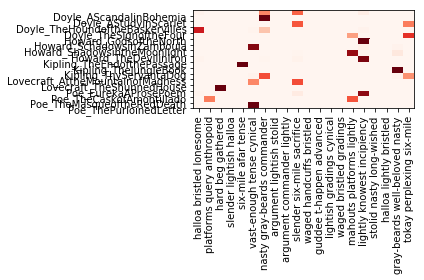

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

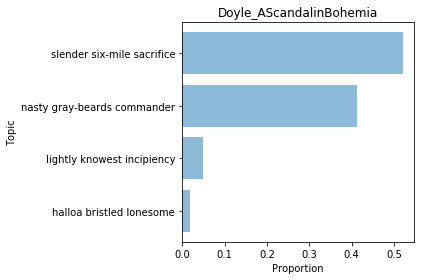

In [30]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)